Hello, this python notebook is a show-how i clean all those web-scrapped excel files.
the data was pre-preprocesed using SED ,  AWK y BASH , converting to csv files using libreoffice headless program, awk for selecting specific rows and SED to replace TABS with comas.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os
import sys

import calendar
from copy import copy as copy

The total of files scraped were:

In [3]:
!ls ./data/cleaned/ | wc | awk '{print $1}'

236


already check the integrity of the scraped data, we proceed to read all the files and start labeling with a correspondig date parameter \[month, day\]

In [4]:
_relative_path = "./data/cleaned/"

In [5]:
files_names = [[None] * 31 for ii in range(12)]
for ii in os.listdir(_relative_path):
    indx = [int(jj) - 1 for jj in ii.split(".")[0].split("_")[1:]]
    if(len(indx)) < 2:
        month = indx[0]
        day = 0
    else:
        [month, day] = indx
    files_names[month][day] = [_relative_path + ii, (month + 1, day + 1)]

if we have check some of the files , is evident wasn't writed using an specific format or protocol. Every files has some unique style , from initialas of words even spaced to initials of words parsed together. 

Even then, the more evident problem is the 'FERIADO' dates, the people in charge to write the excels files doesnt simple omit those days, they MUST have to set an empty file and filled with the word 'FERIADO' itself. What a waste of time for them and for us (well, me; but every says is improper to redact in first person...)

In [6]:
!grep -i 'F,E,R,I,A,D,O,' ./data/cleaned/* | cut -f 2,3 -d "_" | cut -f 1 -d "." | sed 's/_/ /g' | awk '{print "files_names["$1 - 1"]["$2 - 1"] = None"}'

files_names[7][29] = None
files_names[10][0] = None
files_names[11][7] = None
files_names[11][24] = None


In [7]:
files_names[7][29] = None
files_names[10][0] = None
files_names[11][7] = None
files_names[11][24] = None

Time to clean (or omit the data in memory, because this notebook is design to be replicated `in execution` and not to alter the source data)

In [8]:
_temp = []
for ii in files_names:
    _temp += [jj for jj in ii if jj is not None]

once we are done cleaning the most obvius *dirty* data, it's time to check de size of each dataframe (1 dataframe per excel file)

In [9]:
_df_set = [[None] * 31 for ii in range(12)]
multi_indx = []
analytics = []
_tmp_multi_indx = []

for jj in files_names:
    for ii in jj:
        if ii is not None:
            temp = pd.read_csv(ii[0], header=1, encoding ='latin1')

            n_vist = temp[temp.columns[0]].values
            n_month = [ii[1][0]] * len(n_vist)
            n_day = [ii[1][1]] * len(n_vist)

            analytics += [len(temp.columns)]
            _tmp_multi_indx += [ii[1]]

            multi_indx += list(zip(n_month, n_day, n_vist))
            _df_set[ii[1][0] - 1][ii[1][1] - 1] = temp
        else:
            pass

In [10]:
_tmp_idx = pd.MultiIndex.from_tuples(_tmp_multi_indx, names=['mes', 'dia'])

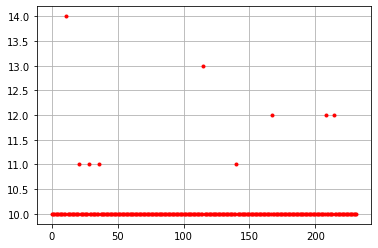

In [11]:
plt.grid()
plt.plot(analytics, '.r')

if it were not enough, with the little standardization of the data it self, even it structure presents variations.

In [12]:
analytics = pd.DataFrame(data=analytics, index=_tmp_idx, columns=["cols"])

In [13]:
analytics[analytics.cols > 10]

cols
mes dia      
1   17     14
    31     11
2   9      11
    21     11
6   16     13
8   18     11
9   27     12
11  24     12
12  4      12

now we know were are the dataframes with extrange amount of columns. by luck are few, it is possible to make a manual clean.

In [14]:
manual_clean = []
special_dates = (np.matrix(analytics[analytics.cols > 10].index.tolist()) -1).tolist()
date_indx = list(zip(special_dates, range(len(special_dates))))
for coords in special_dates:
    manual_clean.append(_df_set[coords[0]][coords[1]])

In [15]:
date_indx

[([0, 16], 0),
 ([0, 30], 1),
 ([1, 8], 2),
 ([1, 20], 3),
 ([5, 15], 4),
 ([7, 17], 5),
 ([8, 26], 6),
 ([10, 23], 7),
 ([11, 3], 8)]

`date_indx` represents the ids of each data frame in question

In [16]:
for jj in range(len(manual_clean)):
    current = manual_clean[jj]
    c_rows = current.shape[0]
    c_vals = current[current.columns[10:]].isna().sum().values
    for ii in range(len(c_vals)):
        ref_len_per_col = c_vals[ii]
        if c_rows != ref_len_per_col:
            print(date_indx[jj])
            aberrant = current[current[current.columns[10 + ii]].notna()]
            display(aberrant)

([0, 16], 0)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
53,54.0,03:05:00 PM,ROBERTO PABLO ROCANO,40485976,LADERSON,PEDRO ZAMBRANO,05:00:00 PM,S1,NaN,NaN,NaN,NaN,NaN,qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq


([0, 30], 1)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10
12,13.0,08:53:00 AM,LUIS RIVAS PATIÑO,46608397,SONDA,GARY DIAZ,05:00:00 PM,6,NaN,NaN,05:17:00 PM


([1, 8], 2)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10
46,47.0,10:28:00 AM,FIORELLA DEMARTINI RIVERA,45432480.0,STUDIO CABALLERO BUSTAMANTE,PEDRO ZAMBRANO,11:43:00 AM,S1,NaN,NaN,...
51,52.0,10:52:00 AM,MIRIAN MONTERO LOZANO,9305107.0,HOSP MARINO MOLINA,GLORIA GUTIERREZ,11:32:00 AM,NaN,NaN,NaN,...


([1, 20], 3)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10
71,72.0,14;98,MICHELET BONILLA ANDRADE,9326454.0,TIP INGENIEROS,MARCOS VELASQUEZ,05:26:00 PM,6,NaN,NaN,LL


([5, 15], 4)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
45,46.0,03:17:00 PM,FABIOLA MORENO JAIME,46085824.0,MINSA,NANCY OLIVARES,04:15:00 PM,8,NaN,NaN,NaN,NaN,...


([7, 17], 5)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


([8, 26], 6)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
40,41.0,02:32:00 PM,FELIX MERINO HENRY,47435983.0,PERSONAL,JULIO CAMBA,05:20:00 PM,4,NaN,NaN,NaN,0.2


([10, 23], 7)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


([11, 3], 8)


,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,:


In [17]:
display(manual_clean[1].loc[12])
manual_clean[1].iloc[12,6] = manual_clean[1].iloc[12,10]
display(manual_clean[1].loc[12])

N° VISITA                                       13
HORA DE INGRESO                        08:53:00 AM
DATOS DEL VISITANTE              LUIS RIVAS PATIÑO
DOCUMENTO DE IDENTIFICACION               46608397
MOTIVO DE VISITA                             SONDA
NOMBRE DEL EMPLEADO  VISITADO          GARY   DIAZ
HORA DE SALIDA                         05:00:00 PM
PISO                                             6
Unnamed: 8                                     NaN
Unnamed: 9                                     NaN
Unnamed: 10                            05:17:00 PM
Name: 12, dtype: object

N° VISITA                                       13
HORA DE INGRESO                        08:53:00 AM
DATOS DEL VISITANTE              LUIS RIVAS PATIÑO
DOCUMENTO DE IDENTIFICACION               46608397
MOTIVO DE VISITA                             SONDA
NOMBRE DEL EMPLEADO  VISITADO          GARY   DIAZ
HORA DE SALIDA                         05:17:00 PM
PISO                                             6
Unnamed: 8                                     NaN
Unnamed: 9                                     NaN
Unnamed: 10                            05:17:00 PM
Name: 12, dtype: object

In [18]:
for ii in range(len(manual_clean)):
    manual_clean[ii] = manual_clean[ii][manual_clean[ii].columns[:10]]
    [x,y] = date_indx[ii][0]
    _df_set[x][y] = manual_clean[ii]

In [19]:
special_multi = pd.MultiIndex.from_tuples(multi_indx, names=['mes', 'dia', 'visita_nro'])

In [20]:
rows_stat = []
exist = []
for ii in range(12):
    for jj in range(31):
        try:
            current = _df_set[ii][jj]
            dims = current.shape
            rows_stat.append(dims[0])
            for kk in range(dims[1]):
                ref_values = current.values[kk]
                ref_def = [ii, jj, kk, len(ref_values)]
                exist.append(ref_def)
        except:
            ref_def = [ii, jj, 0, 10]
        
exist = pd.DataFrame(exist, columns=['mes', 'dia', 'id', 'cols'])

In [21]:
np.unique(exist.cols)

array([10])

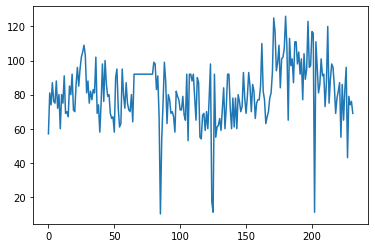

In [22]:
plt.plot(rows_stat)

In [23]:
exist = []
theMaster = []
for ii in range(12):
    for jj in range(31):
        try:
            current = _df_set[ii][jj]
            dims = current.shape
        except:
            ref_def = [ii, jj, 0, 10]
        else:
            for kk in range(dims[0]):
                ref_values = current.values[kk]
                ref_def = [ii, jj, kk, len(ref_values)]
                
                exist.append(ref_def)
                theMaster.append([ *["2017-{:02d}-{:d}".format(ii+1, jj+1)], *ref_values])
        
exist = pd.DataFrame(exist, columns=['mes', 'dia', 'id', 'cols'])

In [24]:
data = pd.DataFrame(theMaster, columns=['date', *_df_set[0][2].columns])
data.shape

(18882, 11)

In [25]:
weird_d = data[data[data.columns[9:]].notna().sum(axis=1) != 0]
aberrants = weird_d.index.values

In [26]:
weird_d.shape

(251, 11)

In [27]:
weird_d[weird_d.columns[9]].notna().sum()

12

In [28]:
weird_d[weird_d[weird_d.columns[9]].notna()]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9
511,2017-01-10,62,11:05:00 AM,PEDRO YUNGO MAMANI,6.09736e+06,PERSONAL,PEDRO MARTINEZ,11:48:00 AM,NaN,,NaN
891,2017-01-17,62,04:05:00 PM,JOHNNY VASQUEZ MALCA,08149275,PERSONAL,MARTHA VILLAR,05:03:00 PM,NaN,,NaN
928,2017-01-18,24,216:00:00,CARLOS MADRID ESPINO,8.07022e+06,CAM RIMAC,LUIS QUIROZ,11:35:00 AM,S1,2,NaN
2834,2017-02-17,51,10:30:00 AM,ISMAEL NAVARRO REATEGUI,40262291,INTEL,ANTENOR RODRIGUEZ,11:26:00 AM,NaN,6,NaN
3734,2017-03-6,49,11:33:00 AM,RAMON ADAM VILELLA,1.09196e+06,REUNION,PIERINA ALVARADO,12:25:00 PM,5,5,NaN
7618,2017-05-12,6,08:30:00 AM,ROGER VERA ZEGARRA,4.13565e+07,ENTREVISTA,HENRY QUISPE,09:20:00 AM,6,6,NaN
10950,2017-08-21,4,08:30,NANCY FERNANDEZ BONIFACIO,4.19538e+07,LABORAL,GLORIA GUTIERREZ,07:23:00 PM,8,./,NaN
12152,2017-09-12,55,02:15:00 PM,EMILIO ORTIZ CUADROS,1.01924e+07,BAC GRAN CONSULTORES,GUISELA GAVIDIA,03:18:00 PM,6,6,NaN
12338,2017-09-15,18,10:15:00 AM,PATRICIA VASQUEZ BARDALES,07558496,SALOG,FELIX MOJOVICH,11:00:00 AM,5,5,NaN
13399,2017-10-3,119,05:08:00 PM,ROCIO RIVERA FRANCO,1.0315e+07,SUMA HUAYNA LLACTA,CARLOS BENAVIDES,07:13:00 PM,9,9,NaN


In [29]:
data.iloc[928][8] = data.iloc[928][9]
data.iloc[2834][8] = data.iloc[2834][9]

print(data.iloc[928][8], data.iloc[2834][8])

2.0 6.0


In [30]:
weird_d[weird_d.columns[10]].notna().sum()

239

In [31]:
weird_d[weird_d[weird_d.columns[10]].notna()]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9
56,2017-01-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
137,2017-01-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
211,2017-01-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
298,2017-01-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
374,2017-01-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...
18583,2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
18662,2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
18736,2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
18812,2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [32]:
to_clean_dev = np.unique(weird_d[weird_d[weird_d.columns[10]].notna()].iloc[:, 10])

In [33]:
to_clean_dev

array([' ', '   ', '0', '9', ':18', 'LLLLL',
       'LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL'],
      dtype=object)

In [34]:
id_x = []
for ii in to_clean_dev[:2]:
    id_x += list(data[data[data.columns[10]] == ii].index.values)

In [35]:
for ii in id_x:
    data.iloc[ii][10] = None

In [36]:
to_clean_dev = to_clean_dev[2:]

In [37]:
id_x = []
for ii in to_clean_dev:
    id_x += list(data[data[data.columns[10]] == ii].index.values)

In [38]:
data.loc[set(id_x), :]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9
14498,2017-10-18,46,12:35:00 PM,LILIANA HERNANDEZ PERALTA,4.02942e+07,RED ´PROCERES,CARMEN MEZA,12:50:00 PM,8,NaN,9
12964,2017-09-27,6,08:50:00 AM,ANA SOTO NAVARRTO,1.06623e+07,RED PUERTO MALDONADO,RISOF SOLIS,05:10:00 PM,8,NaN,0
3047,2017-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLLLL
3049,2017-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL...
4660,2017-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,:18


In [39]:
np.unique(data[data[data.columns[6]] == 'CARMEN MEZA'].PISO)

array(['8', '9'], dtype=object)

In [40]:
data.iloc[14498][8] = data.iloc[14498][10]

In [41]:
data.iloc[14498][8]

'9'

In [42]:
data[data[data.columns[6]] == 'RISOF SOLIS'].PISO.unique()

array(['8', 8.0, '5', '6'], dtype=object)

In [43]:
data.PISO.unique()

array(['6', '7', '8', '5', 'S1', '1', '2', nan, '9', '4', '5t', 'S2',
       '12:45:00 PM', 2.0, 'SI', '54', 'TODOS', '21', 'H', 6.0, '´6', '3',
       '|', '4tp', '5to', 'ST1', '6to', '7mo', '2do', '8vo', '4to', ' ',
       'S1 ', '144:00:00', '87', '63', 8.0, 7.0, 4.0, 1.0, 5.0, '.+',
       '25', '85', 'SOT1', 'S|', '65', '0', '14', '6+', '66', 'S', 'S11',
       '}}', 'S|1', '.', 'STI'], dtype=object)

In [44]:
data[data.PISO == '0']

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9
15157,2017-10-27,20,08:50:00 AM,EVER CADENILLAS CORONEL,2.77285e+07,GERENCIA REGIONAL DE TRANPORTES DE LA LIBERTAD,ELIZABETH YBAÑEZ,09:02:00 AM,0,NaN,NaN


In [45]:
data[data.iloc[:, 9:].notna().sum(axis=1) != 0]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9
511,2017-01-10,62,11:05:00 AM,PEDRO YUNGO MAMANI,6.09736e+06,PERSONAL,PEDRO MARTINEZ,11:48:00 AM,NaN,,NaN
891,2017-01-17,62,04:05:00 PM,JOHNNY VASQUEZ MALCA,08149275,PERSONAL,MARTHA VILLAR,05:03:00 PM,NaN,,NaN
928,2017-01-18,24,216:00:00,CARLOS MADRID ESPINO,8.07022e+06,CAM RIMAC,LUIS QUIROZ,11:35:00 AM,2,2,NaN
2834,2017-02-17,51,10:30:00 AM,ISMAEL NAVARRO REATEGUI,40262291,INTEL,ANTENOR RODRIGUEZ,11:26:00 AM,6,6,NaN
3047,2017-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLLLL
3049,2017-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL...
3734,2017-03-6,49,11:33:00 AM,RAMON ADAM VILELLA,1.09196e+06,REUNION,PIERINA ALVARADO,12:25:00 PM,5,5,NaN
4660,2017-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,:18
7618,2017-05-12,6,08:30:00 AM,ROGER VERA ZEGARRA,4.13565e+07,ENTREVISTA,HENRY QUISPE,09:20:00 AM,6,6,NaN
10950,2017-08-21,4,08:30,NANCY FERNANDEZ BONIFACIO,4.19538e+07,LABORAL,GLORIA GUTIERREZ,07:23:00 PM,8,./,NaN


In [46]:
data.iloc[:, 9:] = None

In [47]:
data[data.iloc[:, 9:].notna().sum(axis=1) != 0]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO,Unnamed: 8,Unnamed: 9


In [48]:
data = data.iloc[:, :9]

In [49]:
data[data.iloc[:,2:].notna().sum(axis=1) == 0]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO
56,2017-01-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,2017-01-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,2017-01-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,2017-01-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,2017-01-6,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
18583,2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18662,2017-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18736,2017-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18812,2017-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
id_x = list(data[data.iloc[:,2:].notna().sum(axis=1) == 0].index.values)

In [51]:
data.drop(id_x, inplace=True)

In [52]:
data[data.iloc[:,1:].notna().sum(axis=1) == 0]

,date,N° VISITA,HORA DE INGRESO,DATOS DEL VISITANTE,DOCUMENTO DE IDENTIFICACION,MOTIVO DE VISITA,NOMBRE DEL EMPLEADO VISITADO,HORA DE SALIDA,PISO


In [53]:
data.index = np.arange(data.shape[0])

In [54]:
data.columns = ['date', 'ord', 't_i', 'd_v', 'di', 'motive', 'd_e', 't_o', 'piso']
# data.to_excel('procesed_data.xlsx')

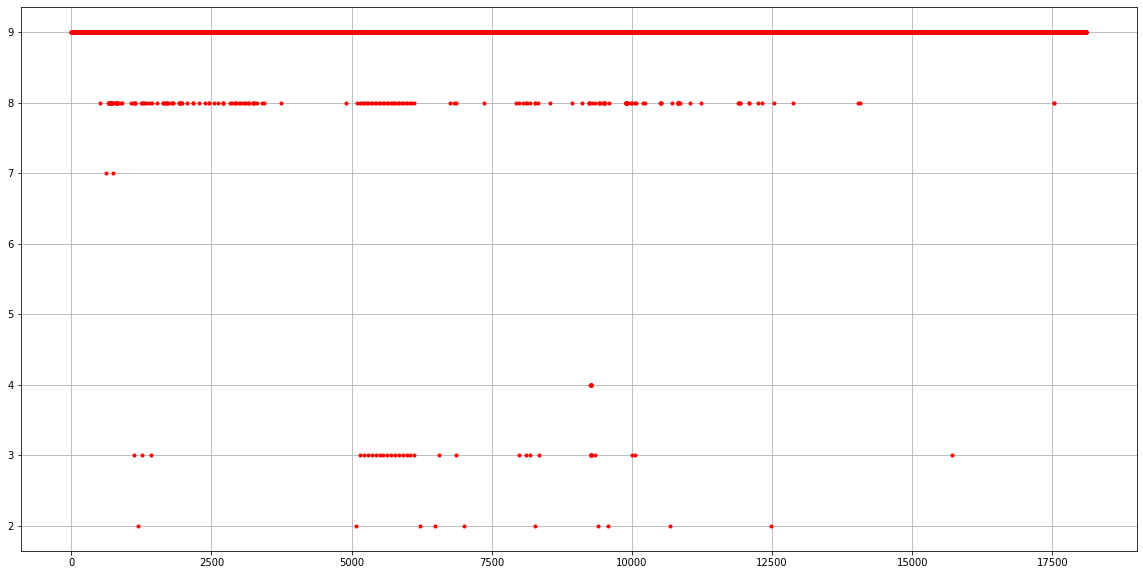

In [55]:
analytics_na = data.notna().sum(axis=1)

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(analytics_na, '.r')

In [56]:
dist_d = analytics_na.value_counts()
dist_d = dist_d.sort_index()

Int64Index([2, 3, 4, 7, 8, 9], dtype='int64') [   10    35     7     2   194 17851]


<BarContainer object of 6 artists>

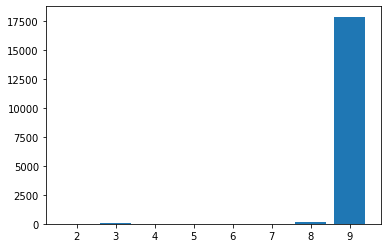

In [57]:

print(dist_d.index, dist_d.values)
plt.bar(dist_d.index, dist_d.values)

2     0.055252
3     0.193381
4     0.038676
7     0.011050
8     1.071882
9    98.629759
dtype: float64

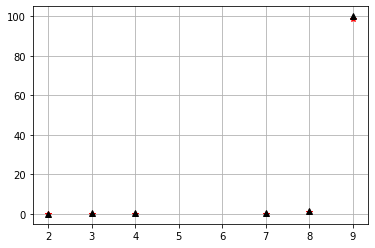

In [58]:
per_dist = ((dist_d / dist_d.sum()) * 100)

display(per_dist)

plt.grid()
plt.plot(per_dist, '*r')
plt.plot(per_dist.cumsum(), '^k')

In [68]:
theREP = data[data.notna().sum(axis=1) == data.shape[1]]
theREP.to_excel('./DATA_98.xlsx')

In [59]:
na_df = data[data.notna().sum(axis=1) != data.shape[1]]
na_df

,date,ord,t_i,d_v,di,motive,d_e,t_o,piso
504,2017-01-10,62,11:05:00 AM,PEDRO YUNGO MAMANI,6.09736e+06,PERSONAL,PEDRO MARTINEZ,11:48:00 AM,NaN
627,2017-01-12,27,09:10:00 AM,HEYSEN SANTILLAN VILLEGAS,4.66561e+07,NaN,CESAR DELGADO,NaN,5
657,2017-01-12,57,12:53:00 PM,JANETH PAREDES CCORIMANYA,4.82816e+07,PERSONAL,MABEL LUNA,NaN,7
673,2017-01-12,73,16:12,MARIA CUADRA CORTEZ,7.32326e+06,PERSONAL,NELLY CORDOVA,NaN,7
681,2017-01-13,2,08:00:00 AM,MARIA AREVALO ABANTO,2.55952e+07,REUNION DE TRABAJO,LUCY VASQUEZ,NaN,2
...,...,...,...,...,...,...,...,...,...
14026,2017-10-23,21,09:08:00 AM,JULIO SANTIAGO ASTO,2.00724e+07,MINSA,NANCY OLIVARES,11:45:00 AM,NaN
14068,2017-10-23,63,11:54:00 AM,MARIA ESCUDERO GONZALES,7.82917e+06,PERSONAL,SONIA MEND0ZA,12:35:00 PM,NaN
15707,2017-11-16,3,FERIADO DECRETADO POR EL PARTIDO,NaN,NaN,NaN,NaN,NaN,NaN
17528,2017-12-19,7,09:08:00 AM,JOSE HUAMAN RAMIREZ,4.51707e+07,SOE,LUIS ALVITEZ,01:38:00 PM,NaN


In [60]:
def see_df_rang(mid, rang):
    return data.iloc[mid - rang:mid +rang, :]

In [61]:
na_df.isna().sum()

date        0
ord        11
t_i        26
d_v        37
di         56
motive     88
d_e        52
t_o       137
piso      106
dtype: int64

the most relevant index where the ones who are unexpendable, in other words : you can't have a visit whitout some to visit. 

Also, lets remember that this data use daily renewed ids, so, if one entrance on a day doesn't have it id, would be trouble-some.

In [62]:
na_df[na_df.d_e.isna()]

,date,ord,t_i,d_v,di,motive,d_e,t_o,piso
1118,2017-01-20,,,NaN,NaN,NaN,NaN,NaN,NaN
1184,2017-01-23,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
1268,2017-01-24,,,NaN,NaN,NaN,NaN,NaN,NaN
1416,2017-01-26,82,,NaN,NaN,NaN,NaN,NaN,NaN
5084,2017-03-31,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
5153,2017-04-3,82,,NaN,NaN,NaN,NaN,NaN,NaN
5222,2017-04-4,82,,NaN,NaN,NaN,NaN,NaN,NaN
5291,2017-04-5,82,,NaN,NaN,NaN,NaN,NaN,NaN
5360,2017-04-6,82,,NaN,NaN,NaN,NaN,NaN,NaN
5429,2017-04-7,82,,NaN,NaN,NaN,NaN,NaN,NaN
